# ICBC Stock Price Analysis and Forecasting (January 2020 - June 2024)

**Author: Zhengling Jiang**

## Introduction

Industrial and Commercial Bank of China (ICBC) is one of the world’s largest commercial banks and a key player in China’s financial system. In this project, we analyze ICBC's A-share stock price performance from January 2020 to June 2024 and build a predictive model to forecast future prices using deep learning.

Our goal is to explore the historical trends in ICBC's stock price by analyzing its price trends, distribution of daily returns, and trading volume. We then conduct a risk analysis by visualizing volatility and calculating Value at Risk (VaR). Finally, we forecast future prices using a Long Short-Term Memory (LSTM) neural network.

This project also reflects my interest in financial data science, and builds upon my internship experience at ICBC. It showcases both technical skills and practical insights into how stock movement can be analyzed and predicted using modern data science tools.


In [1]:
# Import library
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

## Data Loading & Processing

We choose to use `akshare` package to pull daily price data for ICBC A-share.

In [2]:
# Pull daily price data for ICBC A-share
df_icbc = ak.stock_zh_a_daily(symbol="sh601398")

df_icbc['date'] = pd.to_datetime(df_icbc['date'])

# Extract stock price from 2020-01-01 to 2024-06-28
df_icbc = df_icbc[(df_icbc['date'] < '2024-07-01') & (df_icbc['date'] >= '2020-01-01')]

# Show the last few rows
print(df_icbc.tail())

# Show the first few rows
print(df_icbc.head())


           date  open  high   low  close       volume        amount  \
4269 2024-06-24  5.51  5.58  5.50   5.57  331721147.0  1.839293e+09   
4270 2024-06-25  5.56  5.61  5.55   5.60  292474147.0  1.633949e+09   
4271 2024-06-26  5.60  5.66  5.59   5.63  252470534.0  1.420409e+09   
4272 2024-06-27  5.62  5.71  5.60   5.70  315653580.0  1.788966e+09   
4273 2024-06-28  5.69  5.72  5.65   5.70  268553336.0  1.525746e+09   

      outstanding_share  turnover  
4269       2.696122e+11  0.001230  
4270       2.696122e+11  0.001085  
4271       2.696122e+11  0.000936  
4272       2.696122e+11  0.001171  
4273       2.696122e+11  0.000996  
           date  open  high   low  close       volume        amount  \
3187 2020-01-02  5.92  6.03  5.91   5.97  234949397.0  1.404443e+09   
3188 2020-01-03  5.97  6.02  5.96   5.99  152213047.0  9.119516e+08   
3189 2020-01-06  5.96  6.05  5.95   5.97  226509705.0  1.359917e+09   
3190 2020-01-07  5.98  6.04  5.98   6.01  116804353.0  7.016158e+08   
31

**ICBC A-share Data Column Descriptions**

|Column Name | Description                              |
|------------|------------------------------------------|
|`date`      |Trading date                              |
|`open`      |Opening price of the stock on that day (RMB)|
|`high`      |Highest price reached during the day (RMB) |
|`low`       |Lowest price reached during the day (RMB)|
|`close`     |Closing price at the end of trading day |
|`volume`    |Total number of shares traded   |
|`amount`    |Total transaction value in RMB |
|`outstanding_share`|Estimated number of tradable shares in the market (i.e., float) |
|`turnover` |Turnover rate = volume / outstanding shares (represents liquidity)   |

## Exploratory Data Analysis

### Descriptive Statistics about the Data:

We will use .describe() to generate descriptive statistics.

In [3]:
df_icbc.describe()

,date,open,high,low,close,volume,amount,outstanding_share,turnover
count,1087,1087.000000,1087.000000,1087.000000,1087.000000,1.087000e+03,1.087000e+03,1.087000e+03,1087.000000
mean,2022-03-31 23:24:13.909843712,4.875446,4.910294,4.845115,4.879163,2.302320e+08,1.132389e+09,2.696122e+11,0.000854
min,2020-01-02 00:00:00,4.050000,4.060000,4.010000,4.060000,5.562802e+07,2.766231e+08,2.696122e+11,0.000206
25%,2021-02-18 12:00:00,4.630000,4.660000,4.610000,4.630000,1.533560e+08,7.422618e+08,2.696122e+11,0.000569
50%,2022-03-31 00:00:00,4.800000,4.840000,4.770000,4.810000,2.059834e+08,1.003988e+09,2.696122e+11,0.000764
75%,2023-05-16 12:00:00,5.160000,5.195000,5.120000,5.160000,2.742842e+08,1.352429e+09,2.696122e+11,0.001017
max,2024-06-28 00:00:00,5.980000,6.050000,5.980000,6.010000,1.245664e+09,6.850764e+09,2.696122e+11,0.004620
std,NaN,0.375379,0.384745,0.368652,0.377059,1.174659e+08,6.173920e+08,0.000000e+00,0.000436


There are total 1087 records and weekends are not included in the data.

### Price Trends: 

We will demenstrate a line plot of `close` over time.

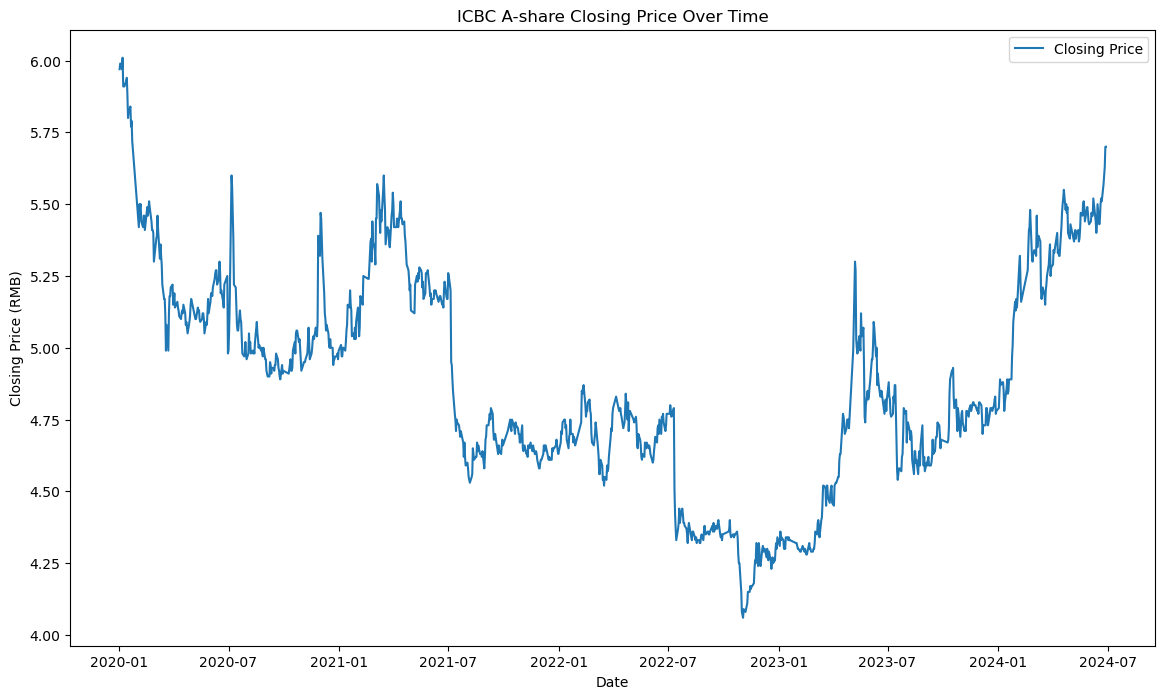

In [4]:
plt.figure(figsize=(14, 8))
plt.plot(df_icbc['date'], df_icbc['close'], label='Closing Price')
plt.title('ICBC A-share Closing Price Over Time')
plt.ylabel('Closing Price (RMB)')
plt.xlabel('Date')
plt.legend()
plt.show()

We will add **moving averages** (30-day window and 90-day window).

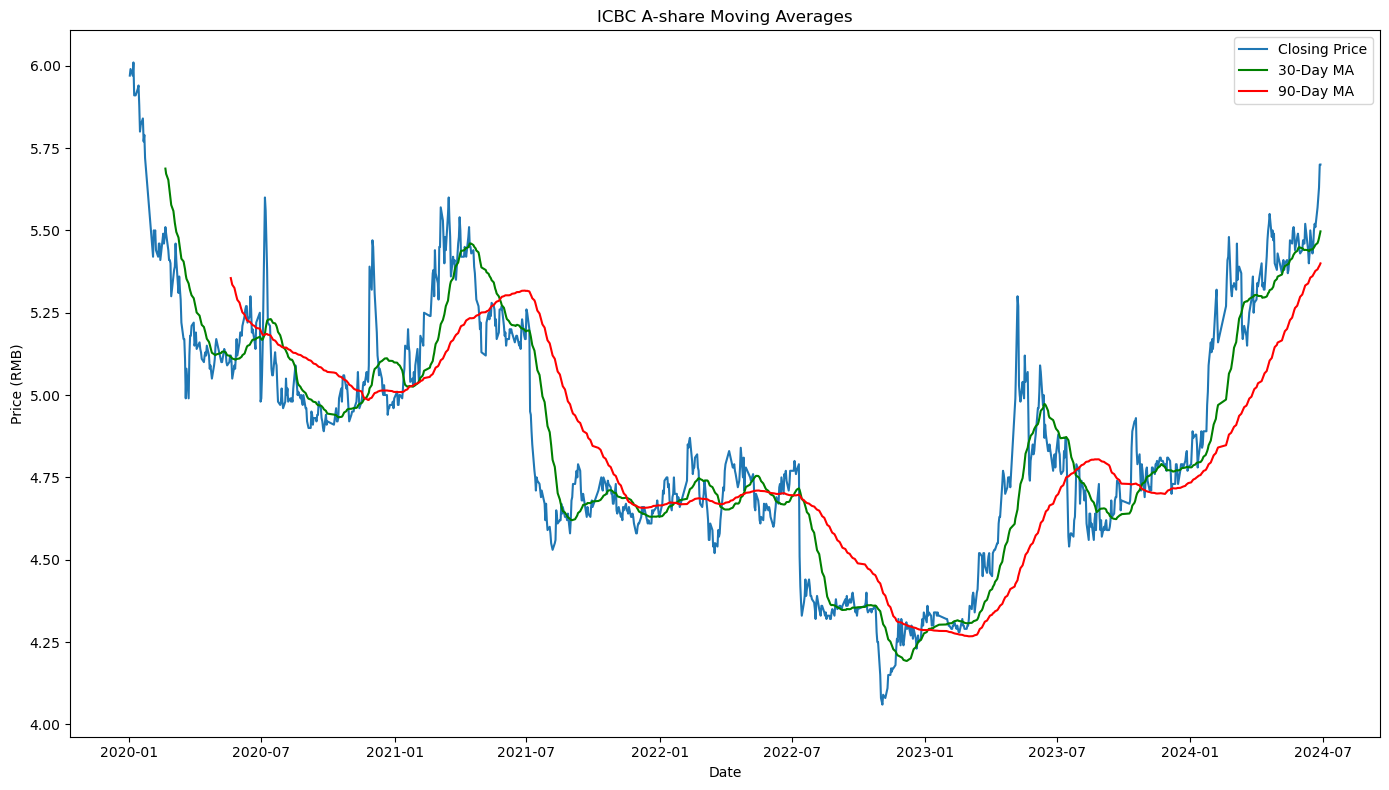

In [5]:
# Add Moving Averages
df_icbc['MA30'] = df_icbc['close'].rolling(window=30).mean()
df_icbc['MA90'] = df_icbc['close'].rolling(window=90).mean()

# Plot the moving averages
plt.figure(figsize=(14, 8))
plt.plot(df_icbc['date'], df_icbc['close'], label='Closing Price')
plt.plot(df_icbc['date'], df_icbc['MA30'], label='30-Day MA', color='green')
plt.plot(df_icbc['date'], df_icbc['MA90'], label='90-Day MA', color='red')
plt.title('ICBC A-share Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (RMB)')
plt.legend()
plt.tight_layout()
plt.show()


This plot shows the daily closing price of ICBC A-share from January 2020 to June 2024, along with the 30-day and 90-day moving averages.

We observe that:
- During the periods of strong price movement (e.g., late 2022 to early 2023), the 30-day MA reacts more quickly to changes, while the 90-day MA lags behind.
- When the 30-day MA **crosses above** the 90-day MA, it often coincides with a **bullish phase** (e.g., early 2023).
- Conversely, when the 30-day MA dips below the 90-day MA, it suggests **bearish pressure**.

Overall, moving averages provide valuable context for understanding price behavior over time, and can assist in indentifying key trend reversal or confirming sustained momentum.

The next plot is about the **distribution of daily return**.

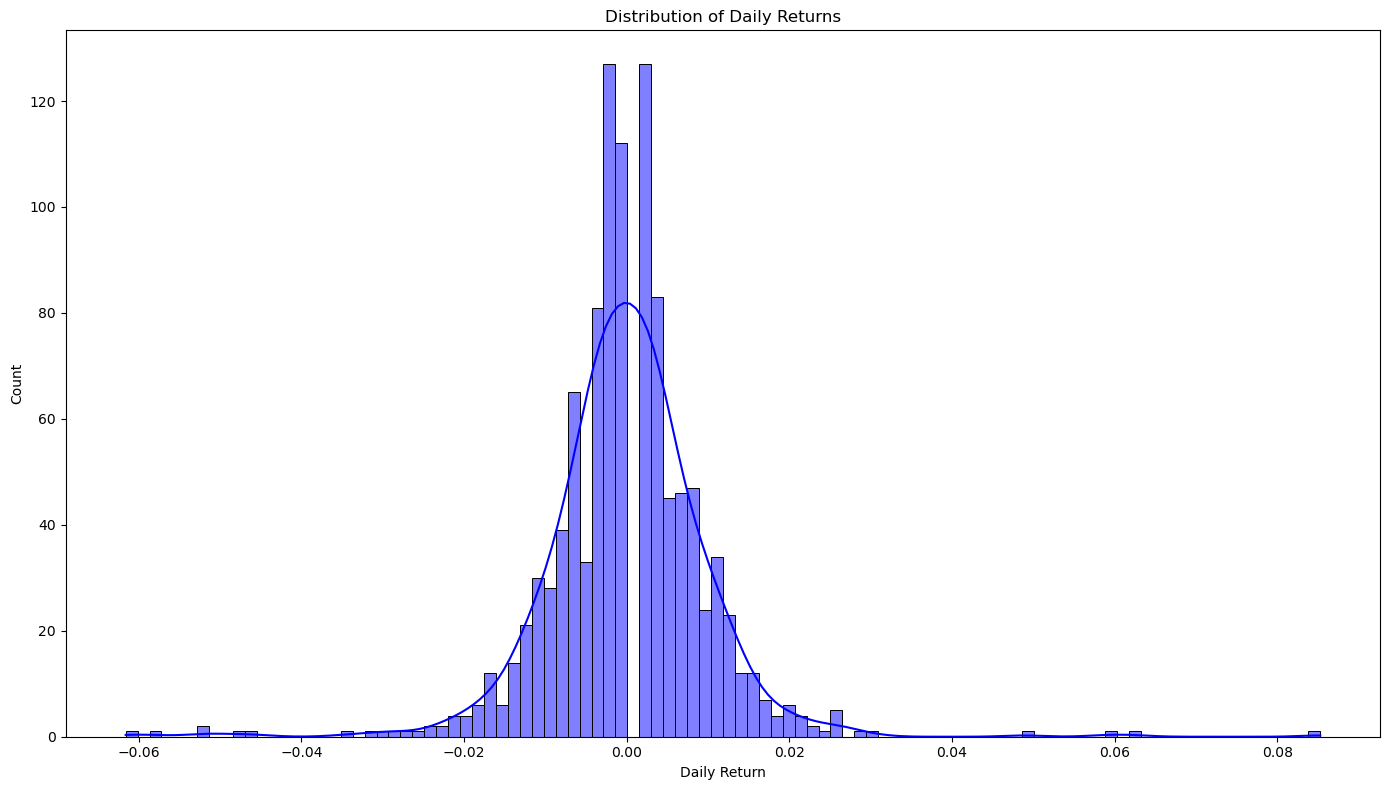

In [6]:
# Daily Return Distribution
df_icbc['daily_return'] = df_icbc['close'].pct_change()

plt.figure(figsize=(14, 8))
sns.histplot(df_icbc['daily_return'].dropna(), bins=100, kde=True, color='blue')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.tight_layout()
plt.show()

This histogram shows that ICBC’s daily returns are centered around 0% but exhibit a right-skewed distribution, indicating occasional large positive returns and relatively low day-to-day volatility.

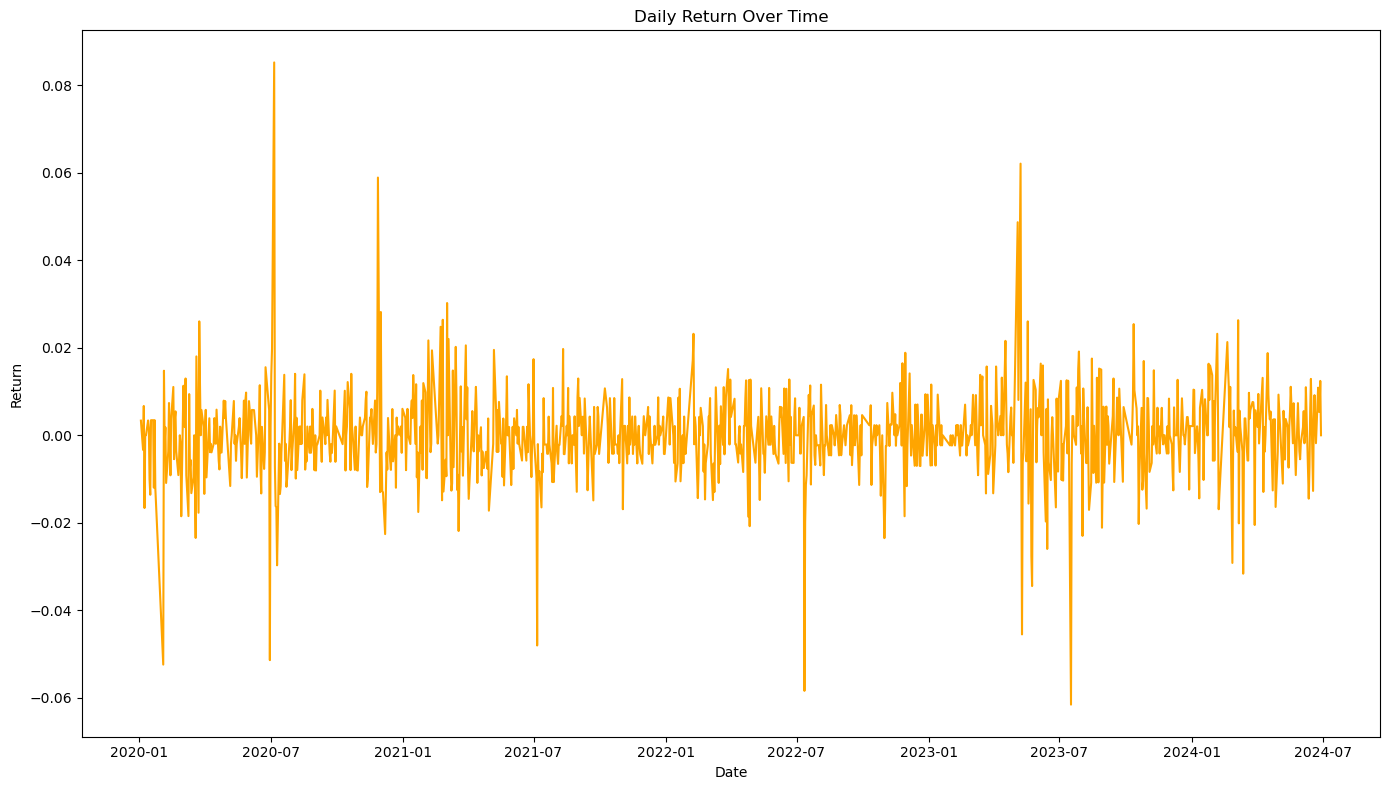

In [7]:
# Daily Return Over Time (Volatility)
plt.figure(figsize=(14, 8))
plt.plot(df_icbc['date'], df_icbc['daily_return'], color='orange')
plt.title('Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.tight_layout()
plt.show()


Based on the plot of daily returns over time, we observe that ICBC's daily return volatility remains relatively low and stable throughout most of the period. However, there are a few noticeable spikes in both positive and negative returns, particularly during mid-2020, early 2021, and mid-2023. These sharp fluctuations may correspond to major economic or company-specific events. Overall, the return series demonstrates a fairly consistent risk profile, with occasional short-term shocks.

Next, we will demonstrate **ICBC's A-share trading volume** from January 2020 to June 2024.

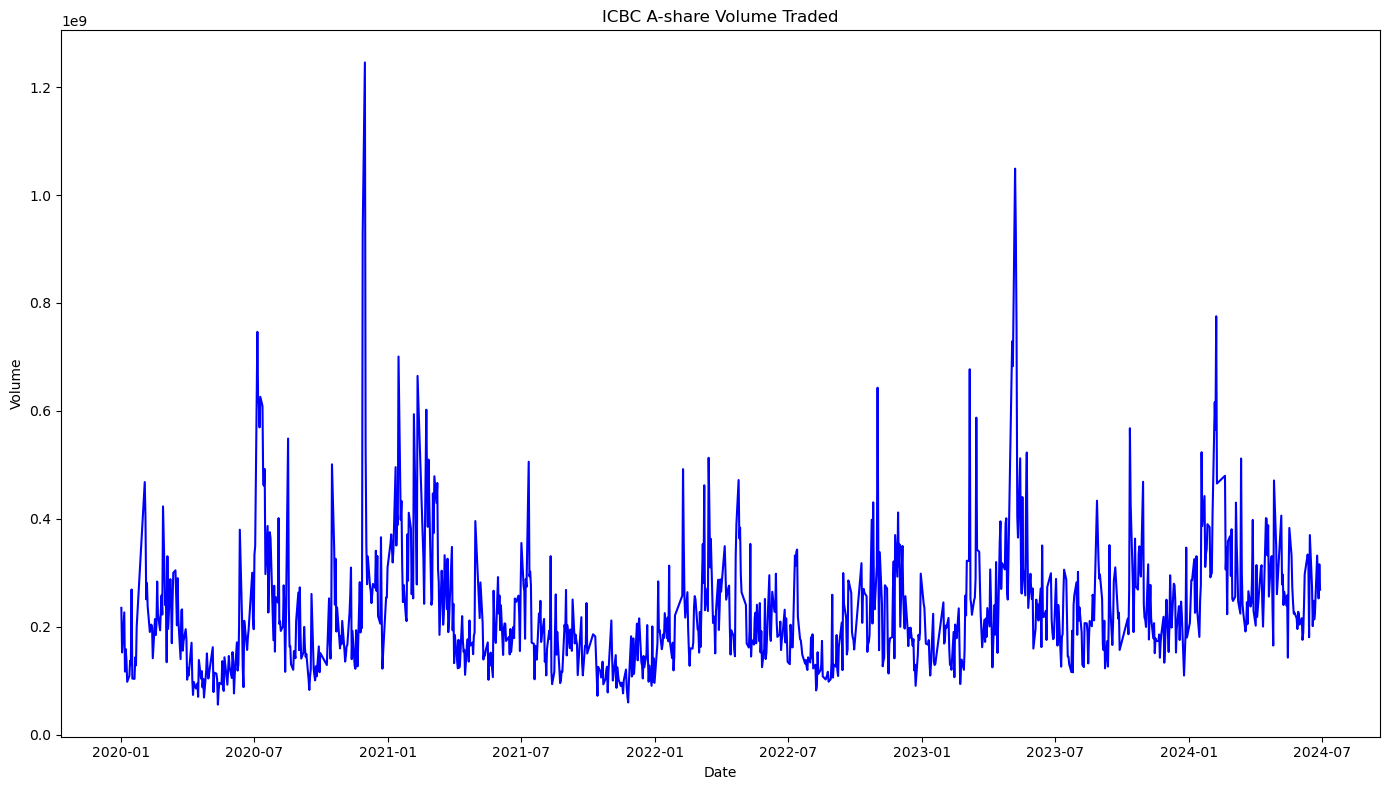

In [8]:
# Volume Traded Over Time
plt.figure(figsize=(14, 8))
plt.plot(df_icbc['date'], df_icbc['volume'], color='blue')
plt.title('ICBC A-share Volume Traded')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

The trading volume plot shows notable spikes throughout the 2020-2024 period, indicating occasional surges in investor activity. Significant peaks appear around mid-2020, early 2021, mid 2023, and early 2024.

## Risk Analysis 

We will carry out risk analysis through visualizing rolling volatility to track how risk changes over time, and calculate historical Value at Risk (VaR) at 95% and 99% confidence levels.


### Calculate Rolling Volatility (Standard Deviation of Returns)

Text(0, 0.5, 'Rolling Volatility (Standard Deviation)')

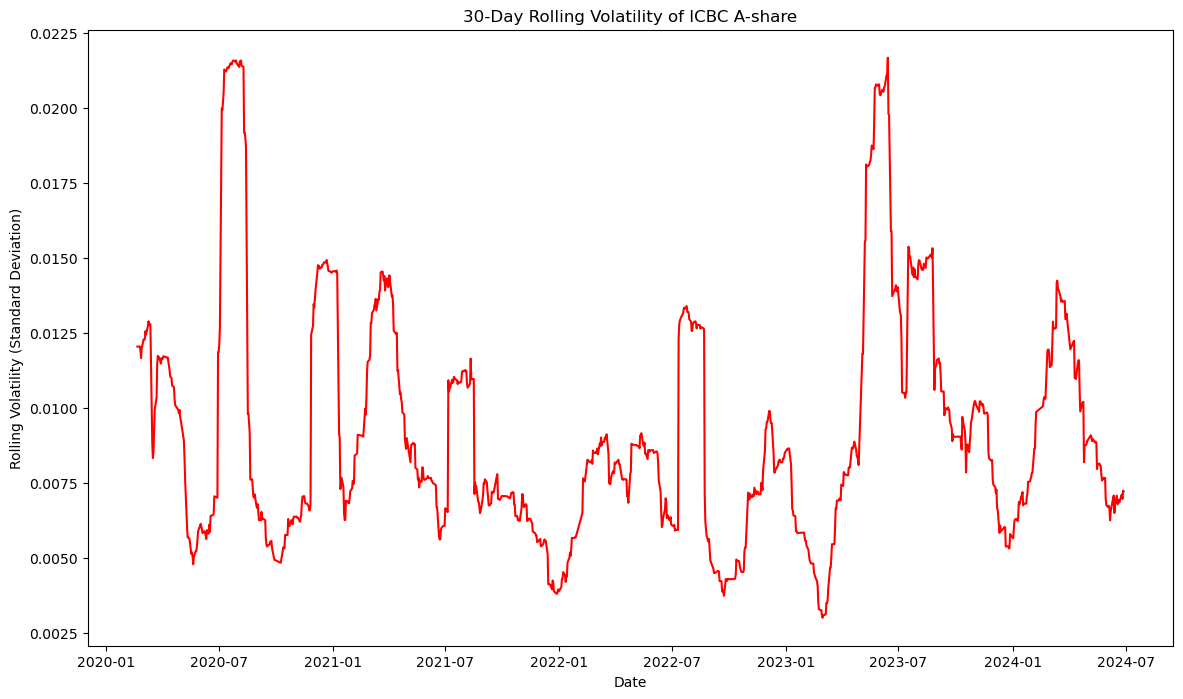

In [9]:
# Calculate 30-day rolling volatility
df_icbc['rolling_volatility'] = df_icbc['daily_return'].rolling(window=30).std()

# Plot
plt.figure(figsize=(14, 8))
plt.plot(df_icbc['date'], df_icbc['rolling_volatility'], color='red')
plt.title("30-Day Rolling Volatility of ICBC A-share")
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (Standard Deviation)')

We observe multiple spikes in volatility, with significant peaks around mid-2020, likely driven by pandemic-related uncertainty, and early 2021, mid-2022, and mid-2023, potentially linked to financial disclosures or market reactions to plolicy announcements. 

### Calculating Historical Value at Risk

In [10]:
returns = df_icbc['daily_return'].dropna()

# Calculate historical VaR at 95% and 99% confidence
var_95 = returns.quantile(0.05)
var_99 = returns.quantile(0.01)

print(f"95% historical VaR: {var_95:.4f} ({var_95*100:.2f}%)")
print(f"99% historical VaR: {var_99:.4f} ({var_99*100:.2f}%)")


95% historical VaR: -0.0135 (-1.35%)
99% historical VaR: -0.0262 (-2.62%)


We calcualte the historical Value at Risk (VaR) at two confidence levels:
- 95% historical VaR: -1.35%
- 99% historical VaR: -2.62%

This means that:
- With 95% confidence, we expect to lose no more than 1.35% on any given day.
- With 99% confidence, we expect that the return will not fall below -2.62%. 

These values suggest that ICBC's A-share price typically exhibits relatively low daily risk, which aligns with the characteristics of a state-owned bank with stable investor expectations.

## ICBC Stock Price Forcasting with LSTM


We will predict the closing price of ICBC's A-share via LSTM, and plot the predicted price with actual price.

### 1. Prepare the Closing Price Data

In [11]:
# Extract closing prices
data = df_icbc[['close']].copy()

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### 2. Create Sequences for LSTM

We'll use 60 days of closing prices to predict the next day. I choose 60 days because 60 days gives the model enough context to learn short-to-medium trends.

In [12]:
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
    
X = np.array(X)
y = np.array(y)

# Reshape to LSTM expected input: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

### 3. Train-Test Split

We will use 80% for training.

In [13]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 4. Build and Train the LSTM Model

#### Define the LSTM Model Architecture

Here we define a Sequential LSTM model architecture consisting of two LSTM layers, one dense hidden layer, and an output layer. This model is designed to capture temporal patterns in ICBC stock price sequences and predict the next price.

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Tune number of units for LSTM layers
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)

    # First LSTM layer with return_sequences=True
    model.add(layers.LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))

    # Second LSTM layer without return_sequences
    model.add(layers.LSTM(units=hp_units))

    # Dense hidden layer with fixed
    model.add(layers.Dense(25, activation='relu'))

    # Output layer
    model.add(layers.Dense(1))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model using Adam optimizer and Mean Squared Error as the loss function.
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')
    return model

#### Hyperparameter Tuning with Keras Tuner

In this section, we apply Random Search Hyperparameter Tuning using the Keras Tuner library.

The goal is to identify better configurations of the LSTM model by experimenting with different hyperparameter values,
such as the number of LSTM units and the learning rate.


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='icbc_lstm_tuning'
)

# Stopping if it does not improve for 3 consecutive epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32,  
    callbacks=[early_stop]
)

Trial 5 Complete [00h 00m 14s]
val_loss: 0.0007542336243204772

Best val_loss So Far: 0.0007542336243204772
Total elapsed time: 00h 01m 34s


#### Retrieve the Best Model

After completing the random search, we retrieve the best-performing hyperparameter combination and rebuild the model using these values.

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Re-train the best model
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Best units: 64
Best learning rate: 0.01
Epoch 1/20


/Users/cj/miniforge3/envs/icbc-stock/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0776 - val_loss: 0.0054
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0014 - val_l

### 5. Predict and Inverse Transform

In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Rescale the true y values
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


### 6. LSTM Model Performance Evaluation

To quantitatively evaluate the model’s prediction accuracy, we compute four standard regression metrics:

- **Root Mean Squared Error (RMSE)**: measures average prediction error magnitude
- **Mean Absolute Error (MAE)**: measures average absolute difference between predicted and actual prices
- **$R^2$ Score**: measures how well the model explains variance in the actual data
- **Mean Absolute Percentage Error**: measures the average absolute percentage difference between actual and predicted values


In [21]:
rmse = np.sqrt(mean_squared_error(real_prices, predictions))
mae = mean_absolute_error(real_prices, predictions)
r2 = r2_score(real_prices, predictions)
mape = np.mean(np.abs((real_prices - predictions) / real_prices)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 0.0674
MAE: 0.0546
R^2 Score: 0.9583
MAPE: 1.0621


The calculation results are:

- **Root Mean Squared Error (RMSE):** 0.0674  
- **Mean Absolute Error (MAE):** 0.0546  
- **$R^2$ Score:** 0.9583  
- **Mean Absolute Percentage Error (MAPE):** 1.06%

These results suggest that:

- The low RMSE and MAE values demonstrate that the model makes only small errors in predicting daily closing prices.
- The $R^2$ score of 0.9583 shows that the model explains over 95% of the variance in actual prices, which reflects a strong overall fit.
- The model's predictions are, on average, only 1.06% away from actual prices, indicating high precision.



### 7. Plor Predicted vs Actual

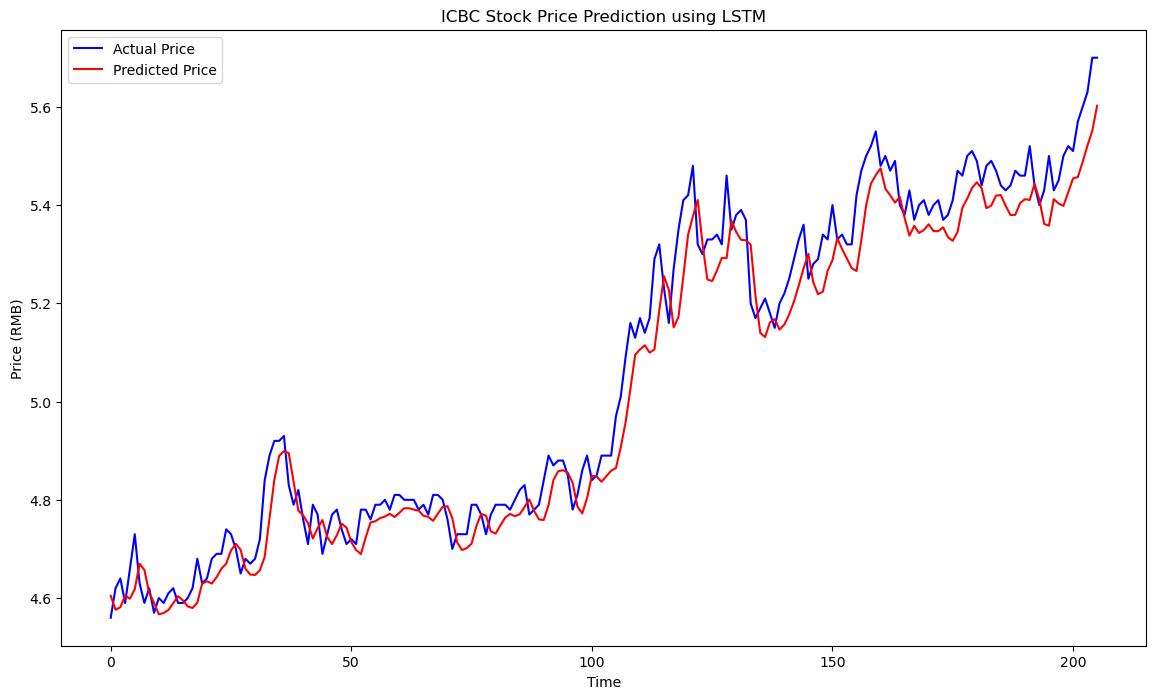

In [23]:
plt.figure(figsize=(14, 8))
plt.plot(real_prices, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('ICBC Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (RMB)')
plt.legend()
plt.show()

The plot above visualizes ICBC A-share the actual stock price alongside thepredictions made by the LSTM model. We observe that the predicted prices follow the overall trend of the actual prices reasonably well, capturing upward and downward movements with some lag. Although the model may slightly fluctuate at times, its ability to track the general trend suggests it has successfully learned useful temporal patterns from historical closing prices.

## Summary

This project analyzes and forecasts the A-share stock price of ICBC from January 2020 to June 2024. We begin with explanatory data analysis, visualizing price trends, trading volume, and the distribution of daily returns. We then conduct risk analysis by calculating 30-day rolling volatility and Value at Risk (VaR) at 95% and 99% confidence levels. These analysis reveals that ICBC's stock prices exhibit stable behavior, with only occasional spikes in volatility likely due to financial disclosures or policy announcements.

To forecast future stock prices, we train a Long Short-term Time Memory (LSTM) neural network using sequences of 60-day historical prices. This model is evaluated using multiple regression metrics, achieving strong results: a Root Mean Squared Error (RMSE) of 0.0674, Mean Absolute Error (MAE) of 0.0546, $R^2$ Score of 0.9583, and Mean Absolute Percentage Error (MAPE) of 1.06%. These metrics suggest that the LSTM model successfully captures useful temporal patterns and perform well in tracking price trends.

Overall, this project combines statistical analysis with deep learning to understand ICBC's stock price behavior and demonstrates how LSTM models can be applied to financial time series data for trend analysis and prediction.  

## Conclusion and Reflection

While stock price prediction models based solely on historical prices have limited predictive power in practice, this project demonstrates my ability to collect real-world financial data, apply time series forecasting techniques, and critically assess model performance.

Importantly, this project builds on my internship experience at ICBC, showing how data science can be applied in the financial domain, even when outcomes must be interpreted with caution. 

Future work could expand this analysis by incorporating additional features such as financial ratios, economic indicators, or sentiment analysis to enhance predictive performance and business relevance.